### Same as Untitled9 but for G20, not DvH

In [1]:
from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import pandas as pd
pd.options.display.mpl_style = 'default'

from mpltools import style
from mpltools import layout

style.use('ggplot')

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size, height=100):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
## see https://stackoverflow.com/questions/14656852/how-to-use-pandas-dataframes-and-numpy-arrays-in-rpy2
## and http://ipython.org/ipython-doc/rel-0.13/config/extensions/rmagic.html
## note there's a ri2pandas() to convert back.
## but note, rpy2 2.4.0 and later automagically translates dataframes: 
## https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
%load_ext rpy2.ipython
%Rdevice svg
#import rpy2.robjects.pandas2ri as p2r
#rdf = p2r.pandas2ri(info)
#%Rpush rdf

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
#%run -i read_counts.py
all_freqs = pickle.load(open('all_freqs.pkl', 'rb'))

In [5]:
sample_info = pd.read_excel('Sample_Info_FIXED2.xlsx') ##,skiprows=[0])
sample_info = sample_info.drop( ['growth rate per h (OLD)', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Sample name.1'], 1)
sample_info = sample_info.set_index( sample_info['Sample name'] )
sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
print sample_infos.keys()
info = sample_infos['Desulfovibrio_alaskensis_G20_uid57941'].copy()
sizeme(info.head(3),50,120)

['Desulfovibrio_alaskensis_G20_uid57941', 'Desulfovibrio_vulgaris_Hildenborough_uid57645', 'Methanococcus_maripaludis_S2_uid58035', 'Methanospirillum_hungatei_JF_1_uid58181']


,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_ISB-1,Sample_ISB-1,Genewiz,SS01-ISB1,LS 37C G20 log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D. alaskensis G20,0.027
Sample_ISB-10,Sample_ISB-10,Genewiz,SS10-ISB10,PS 37C G20 e. stat 1,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",fermentation,pyruvate 20mM,pyruvate,20,none,0.001,37,D. alaskensis G20,0.035
Sample_ISB-11,Sample_ISB-11,Genewiz,SS11-ISB11,PS 37C G20 e. stat 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",fermentation,pyruvate 20mM,pyruvate,20,none,0.001,37,D. alaskensis G20,0.035


### Identify groups of replicates in the measurements -- using groupby

In [6]:
#info_tmp = info[info.columns[np.hstack([4,np.arange(6,14)])]]  ##.duplicated()
group_cols = info.columns[np.hstack([4,6,7,8,9,11,13,14])].values.astype(str).tolist()
#grouped = info.groupby(info.columns[np.hstack([4,np.arange(6,14)])].values)
#group_cols = ['cultivation type', 'Description/condition details',
#             'Description/condition details -2', 'carbon source', 'electron donor',
#             'concentration (mM)', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
print group_cols
grouped = info.groupby(group_cols, axis=0)
print len(grouped.groups), info.shape, info[group_cols].drop_duplicates().shape
#print grouped.groups[grouped.groups.keys()[0]]
print [len(i) for i in grouped.groups.values()]
col_groups = grouped.groups.values()
for i in grouped.groups.values():
    print i
    #print info.ix[i]['Description/condition details'].values
col_groups = grouped.groups.values()

['cultivation type', 'Description/condition details', 'Description/condition details -2', 'carbon source', 'electron donor', 'electron acceptor', 'T0C', 'organisms']
10 (30, 16) (10, 8)
[3, 3, 3, 3, 3, 3, 4, 3, 3, 2]
['Sample_ISB-4', 'Sample_ISB-5', 'Sample_ISB-6']
['Sample_ISB-13', 'Sample_ISB-14', 'Sample_ISB-15']
['Sample_ISB-10', 'Sample_ISB-11', 'Sample_ISB-12']
['Sample_ISB-1', 'Sample_ISB-2', 'Sample_ISB-3']
['Sample_ISB-16', 'Sample_ISB-17', 'Sample_ISB-18']
['Sample_ISB-22', 'Sample_ISB-23', 'Sample_ISB-24']
['Sample_UW1', 'Sample_UW2', 'Sample_UW3', 'Sample_UW4']
['Sample_ISB-7', 'Sample_ISB-8', 'Sample_ISB-9']
['Sample_ISB-19', 'Sample_ISB-20', 'Sample_ISB-21']
['Sample_UW5', 'Sample_UW6']


## OK, idea: remove all replicates of a given measurement, run Boruta to get big, best subset of variables that classify, then random forest (lots of trees) using those variables to get classifier. Test (predict) the random forest on the left-out measurements.

### Now do it for all test cases! -- i.e., all replicate sets

In [7]:
x = all_freqs['Desulfovibrio_alaskensis_G20_uid57941'].copy()
print x.shape
%Rpush x
genes = x.index.values.astype('str')
%Rpush genes
%R -n colnames(x) <- gsub('X..','',gsub('...1.','',colnames(x),fixed=T),fixed=T)
%Rpush info

(3369, 30)


In [8]:
%%R -n
    good_gene = which(!substr(genes,1,2)=='__' & apply(x,1,sum)>0)
    x = x[good_gene,]
    rownames(x)=genes[good_gene]
    x.orig = x = as.matrix(x); NULL

NULL


In [9]:
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))

[1] 10


In [82]:
%%R -n
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)

getY <- function(cond_type, info) {
    if (cond_type == 'growth_rate') {
        gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
        Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    } else if (cond_type == 'electron_donor') {
        Y <- as.factor(as.character(info$electron.donor))
    } else if (cond_type == 'electron_acceptor') {
        Y <- as.factor(as.character(info$electron.acceptor))
    } else if (cond_type == 'temperature') {
        Y <- as.factor(as.character(info$T0C == 37))
    } else if (cond_type == 'all') {
        Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
        Y2 <- as.character(info$electron.donor)
        Y3 <- as.character(info$electron.acceptor)
        Y4 <- as.character(info$T0C == 37)
        Y <- as.factor(paste(Y1, Y2, Y3, Y4))
    }
    names(Y) <- info$Sample.name
    cat(cond_type, length(levels(Y)), '\n')   
    return(Y)
}

do_it <- function(cond_type, x, cols_exclude=NULL, genes_exclude=NULL, n_trees=100000) {
#     if (cond_type == 'growth_rate') {
#         gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
#         Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
#     } else if (cond_type == 'electron_donor') {
#         Y <- as.factor(as.character(info$electron.donor))
#     } else if (cond_type == 'electron_acceptor') {
#         Y <- as.factor(as.character(info$electron.acceptor))
#     } else if (cond_type == 'temperature') {
#         Y <- as.factor(as.character(info$T0C == 37))
#     } else if (cond_type == 'all') {
#         Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
#         Y2 <- as.character(info$electron.donor)
#         Y3 <- as.character(info$electron.acceptor)
#         Y4 <- as.character(info$T0C == 37)
#         Y <- as.factor(paste(Y1, Y2, Y3, Y4))
#     }
#     #cat(cond_type, length(levels(Y)), '\n')
#     names(Y) <- info$Sample.name
    Y <- getY(cond_type, info)

    cols2 <- ''
    if ( ! is.null(cols_exclude) ) cols2 <- gsub('-','.',cols_exclude,fixed=T)

    YY <- Y
    if ( ! is.null(cols_exclude) ) YY <- Y[!names(Y)%in%cols_exclude]
        
    XX <- x
    if ( ! is.null(cols_exclude) ) XX <- XX[, !colnames(XX) %in% cols2, drop=F]
    if ( ! is.null(genes_exclude) ) XX <- XX[!rownames(XX) %in% genes_exclude, ,drop=F]
    #print(dim(XX));print(length(YY))

    features <- character()
    B.temp1a <- try(Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees, doTrace=0))
    if (class(B.temp1a) != 'try-error') features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
    if (class(B.temp1a) == 'try-error' || length(features) < 2) {
        B.temp1a <- try(Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees*2, doTrace=0))
        if (class(B.temp1a) != 'try-error') features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
    }
        
    if (length(features) < 2) features <- rownames(XX)        
    rf.temp1a <- randomForest(t(XX[features, ,drop=F]), YY, importance=T, ntree=n_trees, do.trace=F)
    tmp <- list(predicted=predict(rf.temp1a, t(x[features,cols2,drop=F])), actual=Y[cols_exclude], features=features)
    
    return(tmp)
}
NULL

NULL


In [ ]:
%%R 
results = list()
for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
    tmp <- mclapply( col_groups, function(cols) {
        cols = unlist(cols)
        tmp <- do_it(cond_type, x.ranks, cols)
        #cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        return(tmp)
    }, mc.preschedule=F )
    cat(cond_type, mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual'))), '\n')
    results[[cond_type]] <- tmp
}

In [13]:
%R print(sapply(results,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
%R print(sapply(results,function(tmp)length(levels(unlist(lapply(tmp,'[[','actual'))))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results

   electron_donor electron_acceptor       temperature       growth_rate 
        0.8000000         0.8000000         0.9333333         0.8666667 


   electron_donor electron_acceptor       temperature       growth_rate 
                2                 3                 2                 2 


### For comparison, do it for the full data sets in which we did not leave any conditions out

In [15]:
%%R
    results_noleaveout = list()
    for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
#         if (cond_type == 'growth_rate') {
#             gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
#             Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
#         } else if (cond_type == 'electron_donor') {
#             Y <- as.factor(as.character(info$electron.donor))
#         } else if (cond_type == 'electron_acceptor') {
#             Y <- as.factor(as.character(info$electron.acceptor))
#         } else if (cond_type == 'temperature') {
#             Y <- as.factor(as.character(info$T0C == 37))
#         } else if (cond_type == 'all') {
#             Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
#             Y2 <- as.character(info$electron.donor)
#             Y3 <- as.character(info$electron.acceptor)
#             Y4 <- as.character(info$T0C == 37)
#             Y <- as.factor(paste(Y1, Y2, Y3, Y4))
#         }
#         cat(cond_type, length(levels(Y)), '\n')

        Y <- getY(cond_type, info)
        B.temp1a <- Boruta(t(x.ranks), Y, getImp=getImpFerns, ferns=100000, doTrace=0)
        features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
        
        rf.temp1a <- randomForest(t(x.ranks[features,]), Y, importance=T, ntree=100000, do.trace=F)
        tmp = list(predicted=predict(rf.temp1a), actual=Y, features=features)

        ##print(lapply(tmp,function(i)mean(i$predicted==i$actual)))
        cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        results_noleaveout[[cond_type]] <- tmp
    }

electron_donor 2 
electron_donor 1 
electron_acceptor 3 
electron_acceptor 0.9666667 
temperature 2 
temperature 1 
growth_rate 2 
growth_rate 0.9666667 


In [16]:
%R print(apply(sapply(results_noleaveout,'[[','predicted') == sapply(results_noleaveout,'[[','actual'),2,mean))
%R print(sapply(results_noleaveout,function(tmp)length(levels(tmp$actual))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results_noleaveout

   electron_donor electron_acceptor       temperature       growth_rate 
        1.0000000         0.9666667         1.0000000         0.9666667 


   electron_donor electron_acceptor       temperature       growth_rate 
                2                 3                 2                 2 


### Let's try the removing of the lowest-expressed genes incrementally and see how training/testing works for electron_donor conditions:

##### lets do it by quantiles first, just to see (try 8 quantiles???):

In [17]:
%%R
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)
#cond_type <- 'electron_donor'
qqq <- list()
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
tmp_lst <- lapply( 1:length(col_groups), function(col) {
    #cols = unlist(col_groups[[13]])
    cols <- col_groups[[col]]
    cols <- unlist(cols)
    cols2 <- gsub('-','.',cols)   ## try a pyruvate condition  -- all predicted correctly
    mns <- apply(x.ranks[,cols2, drop=F], 1, median)
    levels <- quantile(mns, inp_quantiles)
    tmp <- mclapply( rev(levels), function(lev) {
        cat(col, 'of', length(col_groups), rev(names(levels))[which(rev(levels)==lev)], lev, sum(mns>lev), cond_type, '\n')
        xx <- x.ranks[mns > lev,, drop=F]
        ttmp <- do_it(cond_type, xx, cols)
        #cat(lev, sum(mns>lev), cond_type, mean(as.character(ttmp$predicted) == as.character(ttmp$actual)), '\n')
        return(ttmp)
    }, mc.preschedule=F )
    #print(apply(sapply(tmp,'[[','predicted') == sapply(tmp,'[[','actual'),2,mean))
    return( tmp )
} )
#print(sapply(tmp_lst,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
qqq[[cond_type]] <- tmp_lst
}

NULL


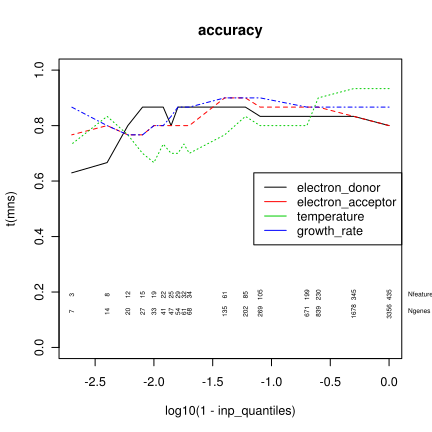

In [97]:
%%R
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
for (k in 1:length(qqq)) for (i in 1:length(qqq$electron_donor)) for (j in 1:length(qqq$electron_donor[[i]])) {
    if (class(qqq[[k]][[i]][[j]]) == 'try-error') qqq[[k]][[i]][[j]] <- list(predicted=factor(),actual=factor(),features=character())
}                                                                                                       

mns <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)tmp2[[lev]]$predicted==unlist(tmp2[[lev]]$actual))))))
colnames(mns)<-names(qqq$growth_rate[[1]])
mns<-mns[,ncol(mns):1]
expr_levels = quantile(apply(x.ranks,1,median),inp_quantiles)
n_genes <- sapply(expr_levels,function(lev)sum(apply(x.ranks,1,median)>lev))

n_features <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)length(tmp2[[lev]]$features))))))
colnames(n_features)<-names(qqq$growth_rate[[1]])
n_features<-n_features[,ncol(n_features):1]

matplot(log10(1-inp_quantiles),t(mns),typ='l',main='accuracy',ylim=c(0,1))
legend('right',legend=rownames(mns),lwd=1,col=1:4)
#text(log10(1-inp_quantiles), 0.5, lab=as.character(round(expr_levels)),cex=0.5,srt=90, xpd=NA)
#text(0.1, 0.5, lab='Rank', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.13, lab=as.character(n_genes),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.13, lab='Ngenes', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.19, lab=as.character(round(apply(n_features,2,mean))),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.19, lab='Nfeatures', pos=4, cex=0.5, xpd=NA)

NULL

In [ ]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
//var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
var command = "NOTEBOOK_FULL_PATH = '" + nb.notebook_path + "'";
kernel.execute(command);

In [ ]:
#%R save.image('qqq')
%Rpush NOTEBOOK_FULL_PATH
%R save.image(paste(gsub('ipynb','RData',NOTEBOOK_FULL_PATH)))

### Get list of (importance-ranked) genes for each condition...

In [104]:
%R -n imp_genes_list <- list()

### First -- electron donor!!!

electron_donor 2 


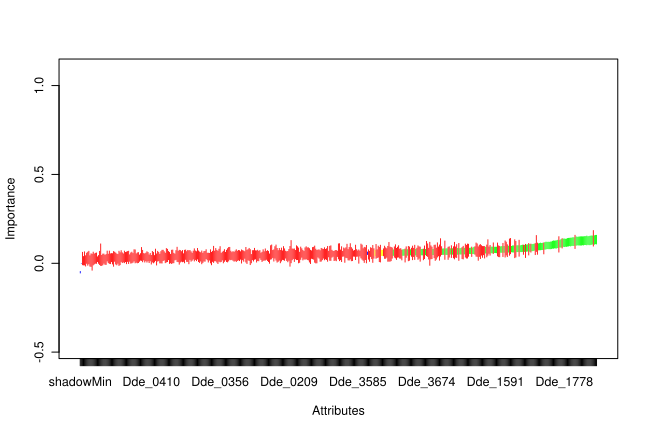

In [108]:
%%R -w 9
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$electron_donor,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=1])
Y <- getY('electron_donor', info)
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
imp_genes_list$electron_donor <- imp_genes

In [109]:
%Rpull imp_genes
print ' '.join(imp_genes)
#query = '%22'+'%22+%22'.join(imp_genes)+'%22'
#query = 'http://networks.systemsbiology.net/search?q='+query
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

Dde_2328 Dde_0328 Dde_2265 Dde_0326 Dde_1354 Dde_0808 Dde_3641 Dde_0989 Dde_0327 Dde_1170 Dde_2700 Dde_0725 Dde_0517 Dde_0990 Dde_2753 Dde_0986 Dde_0985 Dde_0197 Dde_3640 Dde_0984 Dde_3730 Dde_1353 Dde_0512 Dde_0060 Dde_2283 Dde_1109 Dde_0323 Dde_1114 Dde_1778 Dde_0324 Dde_2698 Dde_0227 Dde_0392 Dde_2470 Dde_1450 Dde_0370 Dde_3696 Dde_2188 Dde_3697 Dde_3596 Dde_0988 Dde_0612 Dde_0987 Dde_1797 Dde_0584 Dde_1677 Dde_2966 Dde_1113 Dde_2866 Dde_0286 Dde_3492 Dde_2270 Dde_1185 Dde_1074 Dde_3569 Dde_3695 Dde_0860 Dde_1341 Dde_3493 Dde_1950 Dde_1815 Dde_0288 Dde_3530 Dde_0572 Dde_2708 Dde_3355 Dde_1110 Dde_1395 Dde_0610 Dde_1591 Dde_1547 Dde_2525 Dde_2934 Dde_2931 Dde_0039 Dde_1429 Dde_1143 Dde_3540 Dde_0371 Dde_0710 Dde_0864 Dde_1847 Dde_0863 Dde_1181 Dde_0692 Dde_0694 Dde_3702 Dde_3597 Dde_2309 Dde_1665 Dde_1111 Dde_0057 Dde_0693 Dde_0426 Dde_3198 Dde_0240 Dde_0108 Dde_0355 Dde_0354
http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery=Dde_2328+OR+Dde_0328+O

### Second -- electron acceptor!!!

electron_acceptor 3 


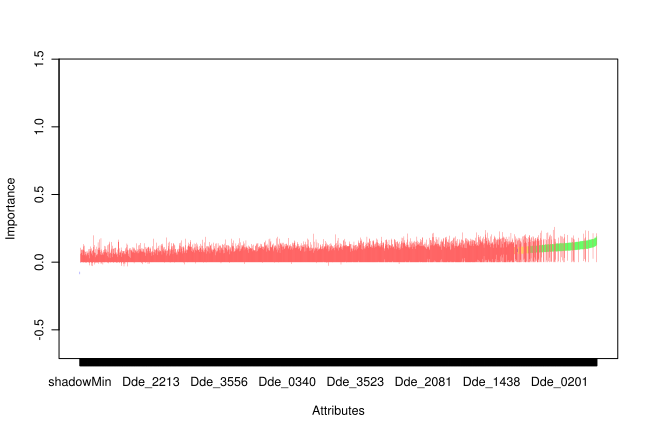

In [112]:
%%R -w 9
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$electron_acceptor,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=1])
Y <- getY('electron_acceptor', info)
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
imp_genes_list$electron_acceptor <- imp_genes

In [113]:
%Rpull imp_genes
print ' '.join(imp_genes)
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

Dde_0282 Dde_1947 Dde_1313 Dde_3187 Dde_2575 Dde_1810 Dde_2153 Dde_3320 Dde_0358 Dde_0526 Dde_1175 Dde_2303 Dde_0871 Dde_2126 Dde_2125 Dde_3245 Dde_3476 Dde_2275 Dde_2233 Dde_3160 Dde_1312 Dde_2252 Dde_2255 Dde_2607 Dde_1133 Dde_3151 Dde_2237 Dde_0333 Dde_2232 Dde_R0003 Dde_0992 Dde_R0022 Dde_2011 Dde_0151 Dde_0681 Dde_1729 Dde_2396 Dde_2648 Dde_3195 Dde_1365 Dde_2263 Dde_0341 Dde_2258 Dde_R0060 Dde_2231 Dde_3144 Dde_2512 Dde_1470 Dde_1096 Dde_0334 Dde_1344 Dde_1761 Dde_0978 Dde_2652 Dde_2234 Dde_2638 Dde_2250 Dde_R0077 Dde_1509 Dde_2251 Dde_2318 Dde_2429 Dde_0011 Dde_2084 Dde_1670 Dde_0077 Dde_1688 Dde_2031 Dde_3046 Dde_1474 Dde_1527 Dde_1345 Dde_3775 Dde_0513 Dde_0196 Dde_2844 Dde_0991 Dde_2994 Dde_1152 Dde_2439 Dde_0261 Dde_2488 Dde_2527 Dde_2989 Dde_2742 Dde_1757 Dde_0228 Dde_1767 Dde_3028 Dde_1201 Dde_2049 Dde_0185 Dde_1393 Dde_2080 Dde_0819 Dde_3183 Dde_0201 Dde_2047 Dde_1635 Dde_1577 Dde_2069 Dde_1132 Dde_2079 Dde_3470 Dde_2998 Dde_0211 Dde_0401 Dde_1594 Dde_0519 Dde_0996 Dde_17

### Third -- temperature!!!

temperature 2 


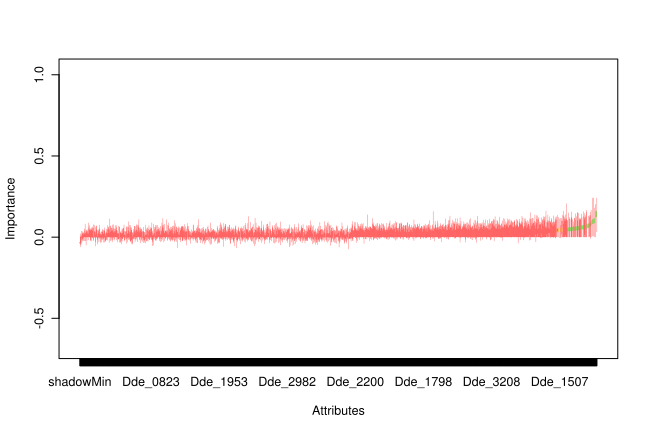

In [114]:
%%R -w 9
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$electron_acceptor,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=1])
Y <- getY('temperature', info)
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
imp_genes_list$temperature <- imp_genes

In [115]:
%Rpull imp_genes
print ' '.join(imp_genes)
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

Dde_0295 Dde_1010 Dde_3205 Dde_1534 Dde_3119 Dde_3647 Dde_R0056 Dde_3598 Dde_4038 Dde_R0009 Dde_3231 Dde_0479 Dde_1035 Dde_2930 Dde_1691 Dde_3028 Dde_1106 Dde_2320 Dde_3293 Dde_1570 Dde_3042 Dde_1033 Dde_2315 Dde_2872 Dde_3417 Dde_0211 Dde_3036 Dde_2049 Dde_3599 Dde_3038 Dde_1547 Dde_0377 Dde_0908 Dde_2411 Dde_1049 Dde_3025 Dde_3064 Dde_1595 Dde_0546 Dde_1726 Dde_0819 Dde_2006 Dde_2772 Dde_0163
http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery=Dde_0295+OR+Dde_1010+OR+Dde_3205+OR+Dde_1534+OR+Dde_3119+OR+Dde_3647+OR+Dde_R0056+OR+Dde_3598+OR+Dde_4038+OR+Dde_R0009+OR+Dde_3231+OR+Dde_0479+OR+Dde_1035+OR+Dde_2930+OR+Dde_1691+OR+Dde_3028+OR+Dde_1106+OR+Dde_2320+OR+Dde_3293+OR+Dde_1570+OR+Dde_3042+OR+Dde_1033+OR+Dde_2315+OR+Dde_2872+OR+Dde_3417+OR+Dde_0211+OR+Dde_3036+OR+Dde_2049+OR+Dde_3599+OR+Dde_3038+OR+Dde_1547+OR+Dde_0377+OR+Dde_0908+OR+Dde_2411+OR+Dde_1049+OR+Dde_3025+OR+Dde_3064+OR+Dde_1595+OR+Dde_0546+OR+Dde_1726+OR+Dde_0819+OR+Dde_2006+OR+Dde_2772+

### Fourth -- growth rate!!!

growth_rate 2 


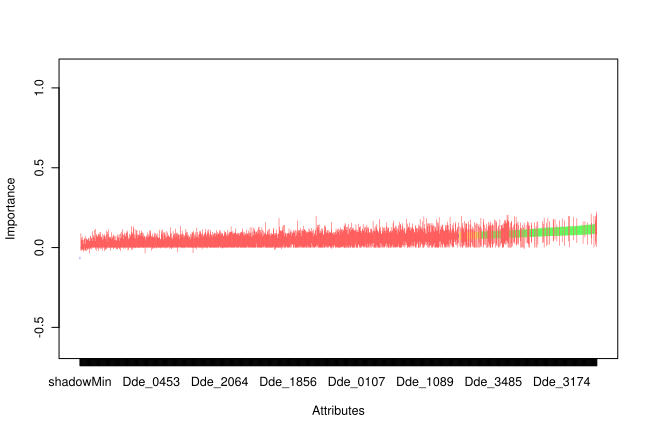

In [116]:
%%R -w 9
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$growth_rate,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=1])
Y <- getY('growth_rate', info)
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
imp_genes_list$growth_rate <- imp_genes

In [117]:
%Rpull imp_genes
print ' '.join(imp_genes)
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

Dde_2056 Dde_0262 Dde_0259 Dde_3151 Dde_0793 Dde_0261 Dde_1810 Dde_3116 Dde_1345 Dde_2233 Dde_0507 Dde_1533 Dde_2257 Dde_2255 Dde_0225 Dde_1728 Dde_0046 Dde_0556 Dde_1406 Dde_2436 Dde_2626 Dde_3160 Dde_1051 Dde_1809 Dde_2691 Dde_0274 Dde_3504 Dde_1729 Dde_2125 Dde_1410 Dde_1509 Dde_2318 Dde_2232 Dde_3279 Dde_2230 Dde_2636 Dde_0333 Dde_2130 Dde_1368 Dde_0557 Dde_1411 Dde_2990 Dde_2639 Dde_0546 Dde_1687 Dde_2527 Dde_2995 Dde_2637 Dde_2252 Dde_1137 Dde_0045 Dde_1312 Dde_R0063 Dde_R0002 Dde_1670 Dde_2234 Dde_3248 Dde_2607 Dde_1764 Dde_0480 Dde_3174 Dde_2393 Dde_0260 Dde_3208 Dde_1527 Dde_2481 Dde_1201 Dde_2069 Dde_3018 Dde_2486 Dde_0201 Dde_1594 Dde_1593 Dde_1596 Dde_2081 Dde_0340 Dde_2413 Dde_1474 Dde_1407 Dde_0176 Dde_3152 Dde_1448 Dde_0682 Dde_0683 Dde_2206 Dde_2381 Dde_2031 Dde_0678 Dde_2507 Dde_0972 Dde_2251 Dde_2478 Dde_0735 Dde_R0060 Dde_1355 Dde_2248 Dde_2200 Dde_3064 Dde_0971 Dde_3614 Dde_1152 Dde_R0055 Dde_1310 Dde_3282 Dde_2055 Dde_0979 Dde_3154 Dde_2181 Dde_2534 Dde_1796 Dde_04

In [ ]:
%R save.image(paste(gsub('ipynb','RData',NOTEBOOK_FULL_PATH)))